In [2]:
import pandas as pd
import re

#Load train and test
train_path = "/content/medical_tc_train.csv"
test_path  = "/content/medical_tc_test.csv"
train_df = pd.read_csv(train_path, sep=",", quotechar='"')
test_df  = pd.read_csv(test_path,  sep=",", quotechar='"')

#Renaming columns
train_df.columns = ["label", "text"]
test_df.columns  = ["label", "text"]

#Combine training and testing datasets
df = pd.concat([train_df, test_df], ignore_index=True)
print(f"✅ Combined dataset size: {len(df)} samples")
df.sample(15)

✅ Combined dataset size: 14438 samples


,label,text
6318,1,Intraepithelial bodies in colorectal adenomas:...
11149,4,Role of angiotensin-converting enzyme inhibito...
11125,3,Postural hypotension: pressor effect of octreo...
13496,1,Local reactions to radioiodine in the treatmen...
761,5,Total gastrectomy for gastric cancer in the el...
2437,4,Transesophageal echocardiography to detect atr...
10609,1,Needle aspiration and pressure sutures for aur...
3135,1,Postoperative active specific immunization in ...
13554,5,Isolation of a complementary DNA clone encodin...
2795,5,Screening of nineteen unrelated families with ...


In [3]:
#Mapping numeric labels to class names
label_map = {
    1: "neoplasm",
    2: "digestive",
    3: "cardio",
    4: "nervous",
    5: "general"
}
df["label_name"] = df["label"].map(label_map)
print("\nClass distribution:")
print(df["label_name"].value_counts())


Class distribution:
label_name
general      4805
neoplasm     3163
nervous      3051
cardio       1925
digestive    1494
Name: count, dtype: int64


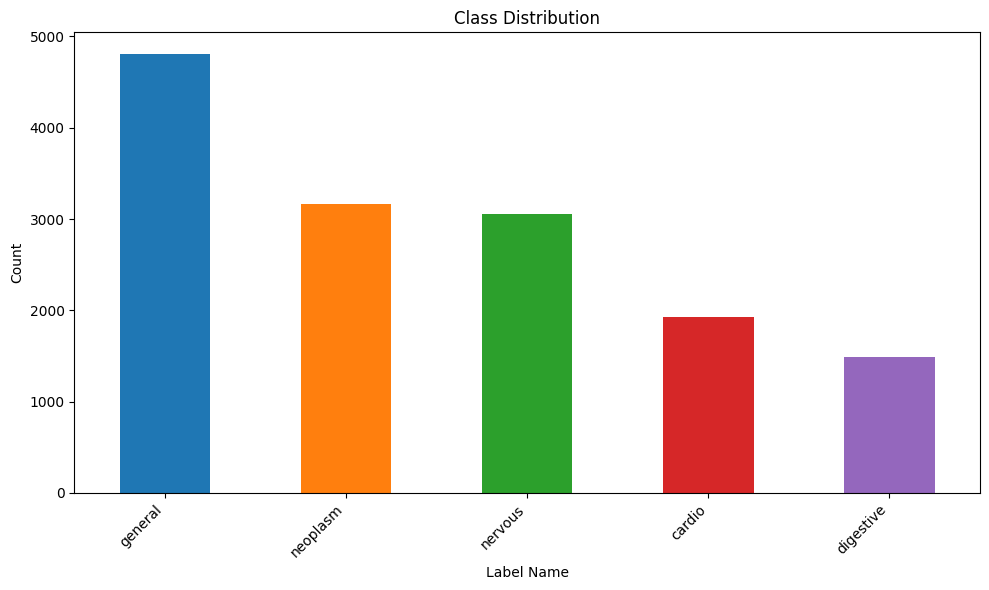

In [19]:
import matplotlib.pyplot as plt

#Bar Chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
plt.figure(figsize=(10, 6))
df['label_name'].value_counts().plot(kind='bar', color=colors)
plt.title('Class Distribution')
plt.xlabel('Label Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
#Cleaning text
def clean_text(t):
    """Lowercase, remove non-alphanumeric chars (keep punctuation minimally)."""
    t = str(t).lower()
    t = re.sub(r'[^a-z0-9\s\-.,]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

df["clean_text"] = df["clean_text"].apply(clean_text)
print("\n✅ Sample after cleaning:")
df.sample(10)


✅ Sample after cleaning:


,label,label_name,clean_text
8707,4,nervous,critical ischemia times and survival patterns ...
2705,5,general,ascending cholangitis surgery versus endoscopi...
322,4,nervous,abdominal aneurysms in childhood report of a c...
11488,5,general,continuous arteriovenous rewarming experimenta...
6997,1,neoplasm,generation of soft x-rays by using the free el...
7444,5,general,recovery from vegetative state of six months d...
8185,3,cardio,cerebral blood flow velocities in the anterior...
13082,5,general,management of gastroenteritis. childhood gastr...
706,1,neoplasm,etoposide in acute leukemia. past experience a...
3146,4,nervous,left ventricular rupture complicating percutan...


In [25]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Removing stopwords from the column
df["clean_text"] = df["clean_text"].apply(
    lambda x: " ".join([word for word in str(x).split() if word.lower() not in stop_words])
)
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   label label_name                                         clean_text
0      5    general  tissue changes around loose prostheses. canine...
1      1   neoplasm  neuropeptide neuron-specific enolase levels be...
2      2  digestive  sexually transmitted diseases colon, rectum, a...
3      1   neoplasm  lipolytic factors associated murine human canc...
4      3     cardio  carotid restenosis predict increased risk late...


In [31]:
#Train test validation split
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 10106
Validation set size: 2166
Test set size: 2166


In [32]:
train_df.sample(15)

,label,label_name,clean_text
4954,5,general,blood rheology cardiac valve replacement mecha...
4498,5,general,glucagonoma syndrome underdiagnosed clinical e...
1734,5,general,natural history segmental wall motion abnormal...
6712,5,general,spinal narcotics postoperative analgesia total...
20,5,general,ear involvement yellow nail syndrome. recogniz...
3791,4,nervous,hypertensive heart disease african-americans. ...
11979,3,cardio,fundoplication gastrostomy familial dysautonom...
12745,1,neoplasm,clinical trials. access reimbursement. clinica...
12718,3,cardio,glossopharyngeal neuralgia associated cardiac ...
3548,2,digestive,results multicenter trial comparing imipenem c...


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.5,
    sublinear_tf=True
)

X_train = tfidf.fit_transform(train_df["clean_text"])
X_val   = tfidf.transform(val_df["clean_text"])
X_test  = tfidf.transform(test_df["clean_text"])

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(metric="cosine", weights="distance", n_neighbors=5)
knn.fit(X_train, train_df["label"])

KNeighborsClassifier(metric='cosine', weights='distance')

In [42]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

best_k = None
best_accuracy = 0

for k in range(1, 31): # Changed the range to 1 to 30
    knn = KNeighborsClassifier(metric="cosine", weights="distance", n_neighbors=k)
    knn.fit(X_train, train_df["label"])
    preds = knn.predict(X_val)
    accuracy = accuracy_score(val_df["label"], preds)
    print(f"k={k} → Accuracy: {accuracy:.3f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"✅ Best k = {best_k} (Accuracy = {best_accuracy:.3f})")

k=1 → Accuracy: 0.427
k=2 → Accuracy: 0.432
k=3 → Accuracy: 0.450
k=4 → Accuracy: 0.463
k=5 → Accuracy: 0.464
k=6 → Accuracy: 0.481
k=7 → Accuracy: 0.482
k=8 → Accuracy: 0.484
k=9 → Accuracy: 0.485
k=10 → Accuracy: 0.490
k=11 → Accuracy: 0.496
k=12 → Accuracy: 0.494
k=13 → Accuracy: 0.500
k=14 → Accuracy: 0.498
k=15 → Accuracy: 0.498
k=16 → Accuracy: 0.498
k=17 → Accuracy: 0.500
k=18 → Accuracy: 0.499
k=19 → Accuracy: 0.500
k=20 → Accuracy: 0.496
k=21 → Accuracy: 0.500
k=22 → Accuracy: 0.501
k=23 → Accuracy: 0.499
k=24 → Accuracy: 0.501
k=25 → Accuracy: 0.500
k=26 → Accuracy: 0.500
k=27 → Accuracy: 0.502
k=28 → Accuracy: 0.500
k=29 → Accuracy: 0.498
k=30 → Accuracy: 0.498
✅ Best k = 27 (Accuracy = 0.502)


In [49]:
train_preds = knn.predict(X_train)
train_acc = accuracy_score(train_df['label'], train_preds)
val_acc = accuracy

print(f"Training accuracy: {train_acc:.2f}")
print(f"Validation accuracy: {val_acc:.2f}")

Training accuracy: 0.84
Validation accuracy: 0.50


In [44]:
import pandas as pd

combined_train = pd.concat([train_df, val_df])
X_combined = tfidf.fit_transform(combined_train["clean_text"])
X_test = tfidf.transform(test_df["clean_text"])

knn_final = KNeighborsClassifier(metric="cosine", weights="distance", n_neighbors=best_k)
knn_final.fit(X_combined, combined_train["label"])

KNeighborsClassifier(metric='cosine', n_neighbors=27, weights='distance')

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
test_preds = knn_final.predict(X_test)
print(classification_report(test_df["label"], test_preds, digits=3))


              precision    recall  f1-score   support

           1      0.578     0.638     0.607       475
           2      0.362     0.321     0.340       224
           3      0.406     0.336     0.367       289
           4      0.555     0.604     0.579       457
           5      0.382     0.374     0.378       721

    accuracy                          0.470      2166
   macro avg      0.457     0.455     0.454      2166
weighted avg      0.463     0.470     0.465      2166



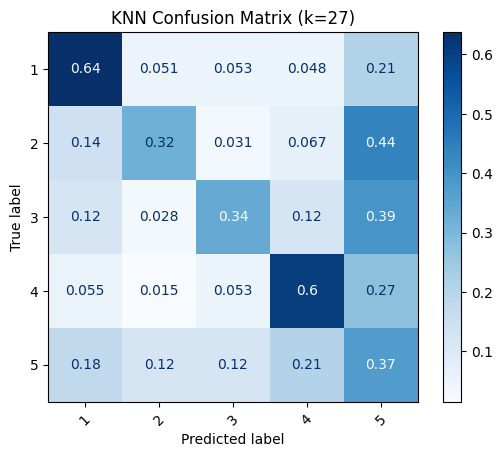

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_df["label"], test_preds, labels=knn_final.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_final.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"KNN Confusion Matrix (k={best_k})")
plt.show()

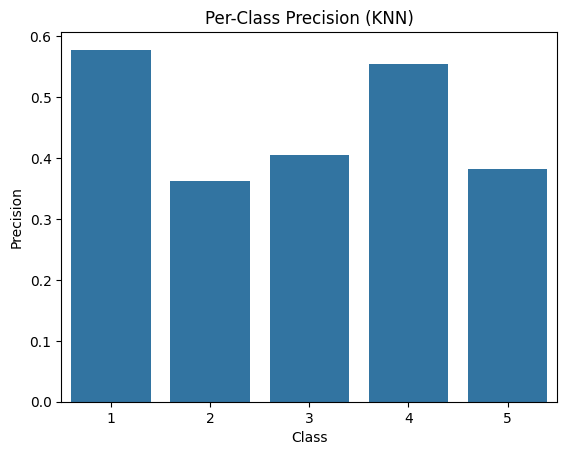

In [47]:
import seaborn as sns
p, r, f, _ = precision_recall_fscore_support(test_df["label"], test_preds, labels=knn_final.classes_)
sns.barplot(x=knn_final.classes_, y=p)
plt.title("Per-Class Precision (KNN)")
plt.ylabel("Precision")
plt.xlabel("Class")
plt.show()